In [151]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [152]:
pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [153]:
pip install sentence-transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [154]:
pip install rank-bm25

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [155]:
import os
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
from scipy.spatial import distance
from sentence_transformers import SentenceTransformer
from tqdm import tqdm
from rank_bm25 import BM25Okapi
from transformers import AutoTokenizer, AutoModel
import torch

from sklearn.metrics.pairwise import cosine_similarity

import math
import numpy as np

In [156]:
codebert_tokenizer = AutoTokenizer.from_pretrained("microsoft/codebert-base")
codebert_model = AutoModel.from_pretrained("microsoft/codebert-base")

In [157]:
bert_model = SentenceTransformer('bert-base-uncased')
bert_model.to(torch.device('cuda:0'))

Some weights of the model checkpoint at /root/.cache/torch/sentence_transformers/bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


SentenceTransformer(
  (0): Transformer({'max_seq_length': 512, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
)

In [158]:
def retrieval_bm25(bm25, file_indexes,  query):    
    tokenized_query = query.split(" ")    
    doc_scores = bm25.get_scores(tokenized_query)
    file_score_dict = {}
    for i in range(len(doc_scores)):
        file_index = file_indexes[i]
        file_score = doc_scores[i]
        file_score_dict[file_index] = file_score

    return file_score_dict

def retrieval_bm25_revised(bm25, file_indexes, query, length_score_dict):
    tokenized_query = query.split(" ")    
    doc_scores = bm25.get_scores(tokenized_query)
    file_score_dict = {}
    for i in range(len(doc_scores)):
        file_index = file_indexes[i]
        length_score = length_score_dict[file_index]
        file_score = doc_scores[i] * length_score
        file_score_dict[file_index] = file_score

    return file_score_dict


def retrieval_tfidf(vectorizer, file_tfidf, file_indexes, query):
    query_tfidf = vectorizer.transform([query])
    sim_scores = cosine_similarity(query_tfidf, file_tfidf).flatten()
    file_score_dict = {}
    for i in range(len(file_indexes)):
        file_index = file_indexes[i]
        file_score = sim_scores[i]
        file_score_dict[file_index] = file_score
    return file_score_dict

def retrieval_tfidf_revised(vectorizer, file_tfidf, file_indexes, query, length_score_dict):
    query_tfidf = vectorizer.transform([query])
    sim_scores = cosine_similarity(query_tfidf, file_tfidf).flatten()
    file_score_dict = {}
    for i in range(len(file_indexes)):        
        file_index = file_indexes[i]
        file_score = sim_scores[i]        
        length_score = length_score_dict[file_index]
        file_score = file_score * length_score
        file_score_dict[file_index] = file_score

    return file_score_dict


def retrieval_bert(bert_model, file_indexes, file_embedding, query):
  query_embedding = bert_model.encode(query)
  sim_score = cosine_similarity([query_embedding],file_embedding)
  file_score_dict = {}
  for i in range(len(file_indexes)):
      file_index = file_indexes[i]
      file_score = sim_score[0][i]
      file_score_dict[file_index] = file_score
  return file_score_dict


def retrieval_codebert(codebert_model, codebert_tokenizer, file_indexes, file_embedding, query):
  tokens = codebert_tokenizer(query, padding=True, truncation=True)
  token_ids = tokens_ids=codebert_tokenizer.convert_tokens_to_ids(tokens)
  query_embedding = codebert_model(torch.tensor(tokens_ids)[None,:])[0]
  embedding = query_embedding[:, 0, :]

  sim_score = cosine_similarity(query_embedding[0].detach().numpy(),file_embedding)
  file_score_dict = {}
  for i in range(len(file_indexes)):
      file_index = file_indexes[i]
      file_score = sim_score[0][i]
      file_score_dict[file_index] = file_score
  return file_score_dict

def retrieval_lsi(dictionary, lsi, index, file_indexes, query):

    vec_bow = dictionary.doc2bow(query.lower().split())
    vec_lsi = lsi[vec_bow]  # convert the query to LSI space
    sims = index[vec_lsi]              
    
    file_score_dict = {}
    for i in range(len(sims)):
        file_index = file_indexes[i]
        file_score = sims[i]
        file_score_dict[file_index] = file_score

    return file_score_dict

def retrieval_jsm(documents_term_prob_matrix, file_indexes, query_term_prob_list):
    
    ind = 0
    file_score_dict = {}
    for doc_probs in documents_term_prob_matrix:
        score = distance.jensenshannon(doc_probs,query_term_prob_list)
        file_id = file_indexes[ind]
        ind += 1
        file_score_dict[file_id] = 1- score
    return file_score_dict


# for JSM
def get_doc_term_probs_jsm(files_corpus):  
    cnt_vectorizer = CountVectorizer(max_features=10000)
    X = cnt_vectorizer.fit_transform(files_corpus)
    X_terms = cnt_vectorizer.get_feature_names()
        
    doc_cnt_matrix = X.toarray()
    term_prob_matrix = []
    for doc in doc_cnt_matrix:
        all_terms = sum(doc)
        new_doc = []
        for cnt in doc:
            value = 0
            if cnt != 0:
                value = cnt / all_terms
            new_doc.append(value)
        term_prob_matrix.append(new_doc)
    return cnt_vectorizer, term_prob_matrix

def get_query_term_probs_jsm(cnt_vectorizer, query):
    X_query = cnt_vectorizer.transform([query])
    query_cnt = X_query.toarray()[0]
    all_terms_query = sum(query_cnt)
    new_query_cnt = []
    for cnt in query_cnt:
        value = 0
        if cnt != 0:
            value = cnt / all_terms_query
        new_query_cnt.append(value)
    return new_query_cnt


def evaluation(sim_scores, gtf_list, files_num, num_top_index):
    sim_scores_sort = sorted(sim_scores.items(), reverse=True, key=lambda item: item[1])
    rank = 1
    top_rank = files_num
    rr = 0
    ap = 0
    find_bug_num = 0
    non_buggy_file_indexes = []
    top_file_indexes = []
    for key, _ in sim_scores_sort:
        if len(gtf_list) == find_bug_num and len(top_file_indexes) == num_top_index:
            break
        if key in gtf_list:
            find_bug_num += 1
            if rr == 0:
                rr = 1.0 / rank
                top_rank = rank
            ap += find_bug_num / rank
        if len(non_buggy_file_indexes) < 10:
            non_buggy_file_indexes.append(key)
        if rank < num_top_index:
            top_file_indexes.append(key)
        rank += 1
    if find_bug_num > 0:
        ap = ap / find_bug_num

    return top_rank, rr, ap, non_buggy_file_indexes, top_file_indexes

    
def evaluation_wt_bfids(sim_scores, gtf_list, files_num, num_top_index):
    sim_scores_sort = sorted(sim_scores.items(), reverse=True, key=lambda item: item[1])
    rank = 1
    top_rank = files_num
    rr = 0
    ap = 0
    find_bug_num = 0
    non_buggy_file_indexes = []
    top_file_indexes = []
    top_buggy_file_ids = []
    for key, _ in sim_scores_sort:
        if len(gtf_list) == find_bug_num and len(top_file_indexes) == num_top_index:
            break
        if key in gtf_list:
            find_bug_num += 1
            if rr == 0:
                rr = 1.0 / rank
                top_rank = rank
            ap += find_bug_num / rank
            top_buggy_file_ids.append(key+":"+str(rank))
        if len(non_buggy_file_indexes) < 10:
            non_buggy_file_indexes.append(key)
        if rank < num_top_index:
            top_file_indexes.append(key)
        rank += 1
    if find_bug_num > 0:
        ap = ap / find_bug_num
    return top_rank, rr, ap, non_buggy_file_indexes, top_file_indexes, top_buggy_file_ids

In [159]:
bugs_path = "/content/drive/MyDrive/data/scaling_data/data/harshit/Denchmark_query/"
files_path = "/content/drive/MyDrive/data/scaling_data/data/harshit/Denchmark_file/"
gtfs_path = "/content/drive/MyDrive/data/scaling_data/data/harshit/Denchmark_gtf/"
irbl_path = "/content/drive/MyDrive/data/scaling_data/data/harshit/Results_bert"
repos = os.listdir(bugs_path)

In [160]:
mrr_vsm = 0
map_vsm = 0
mrr_rvsm = 0
map_rvsm = 0
mrr_bm = 0
map_bm = 0
mrr_codebert = 0
map_codebert = 0

target_bug_num = 0
target_repo_num = 0

In [ ]:
for repo in repos:
    if repo == ".DS_Store":
        continue
    versions = os.listdir(bugs_path+repo)
    project_bug_num = 0
    for version in versions:
        if version == ".DS_Store":
            continue
        files = os.listdir(files_path+repo+"/"+version)
        lang_types = set()
        for file in files:
            if file.endswith(".txt") is False:
                continue
            lang = file.replace("KeyMap.txt", "").lower()
            file_path = files_path+repo+"/"+version+"/"+file
            f = open(file_path, "r", encoding="utf8")
            lines = f.readlines()
            if len(lines) > 0:
                lang_types.add(lang)
        if len(lang_types) == 0:
            continue

        lang_files = {}
        lang_file_ids = {}
        lang_tfidf = {}
        lang_vectorizer = {}
        lang_bm25 = {}
        lang_bert = {}
        lang_length_scores = {}
        for lang_type in lang_types:
            source_files = os.listdir(files_path+repo+"/"+version+"/"+lang_type+"_pp/")
            file_corpus = []
            file_id_list = []
            file_embedding = []
            lengths = []
            max_length = 0
            min_length = 99999
            for source_file in source_files:
                file_id = source_file.split(".")[len(source_file.split("."))-2]
                contents = ' '.join(open(files_path+repo+"/"+version+"/"+lang_type+"_pp/"+source_file, "r", encoding="utf8").readlines()).replace("\n"," ")
                file_corpus.append(contents)
                file_id_list.append(lang_type+"-"+file_id)
                length = len(contents.split())
                lengths.append(length)
                if max_length < length:
                    max_length = length
                if min_length > length:
                    min_length = length
            
            length_score_dict = {}
            for i in range(len(file_id_list)):
                length = lengths[i]
                file_id = file_id_list[i]
                if max_length == min_length:
                    length= 1
                else:
                    length = (length - min_length) / (max_length - min_length)
                if length == 0:
                    length = 1
                length_score = 1 / (1 + math.exp(-length))
                if length_score == 0:
                    length_score = 1
                length_score_dict[file_id] = length_score
            if max_length <= 3 :
                continue
            
            lang_files[lang_type] = file_corpus
            lang_file_ids[lang_type] = file_id_list


            vectorizer = TfidfVectorizer(stop_words='english', max_features = 10000)
            file_tfidf = vectorizer.fit_transform(file_corpus)
            lang_tfidf[lang_type] = file_tfidf
            lang_vectorizer[lang_type] = vectorizer

            tokenized_corpus = [doc.split(" ") for doc in file_corpus]
            bm25_model = BM25Okapi(tokenized_corpus)
            lang_bm25[lang_type] = bm25_model

            for file_text in tqdm(file_corpus):
              file_embedding.append(bert_model.encode(file_text))


            lang_length_scores[lang_type] = length_score_dict

        bugs = os.listdir(bugs_path+repo+"/"+version+"/")
        for bug in bugs:
            if os.path.exists(gtfs_path+repo+"/"+version+"/"+bug+".txt") is False:
                continue
            query = ' '.join(open(bugs_path+repo+"/"+version+"/"+bug+"/query_base-desc.txt", "r", encoding="utf8").readlines()).replace("\n","")
            query_sum = ' '.join(open(bugs_path+repo+"/"+version+"/"+bug+"/query_base-sum.txt", "r", encoding="utf8").readlines()).replace("\n","")
            query = query + " "+query_sum
            query = query.strip()
            lines = open(gtfs_path+repo+"/"+version+"/"+bug+".txt", "r", encoding="utf8").readlines()
            gtf_list = []
            lang_set = set()
            for line in lines:
                line = line.replace("\n","")
                if len(line) < 3:
                    continue
                gtf_list.append(line)
                lang = line.split("-")[0]
                lang_set.add(lang)
            if os.path.exists(irbl_path+"/"+repo+"/"+version+"/"+bug+"/sf_sim/") is False:
                os.makedirs(irbl_path+"/"+repo+"/"+version+"/"+bug+"/sf_sim/")
            for lang in lang_set:
                file_ids = lang_file_ids[lang]
                files_corpus = lang_files[lang]
                vectorizer = lang_vectorizer[lang]
                file_tfidf = lang_tfidf[lang]
                bm_25 = lang_bm25[lang]
                lang_gtf_list = []

                for gtf in gtf_list:
                    if str(gtf).startswith(lang) is True:
                        lang_gtf_list.append(gtf.split("-")[1])
                if len(lang_gtf_list) == 0:
                    continue

                vsm_sim_scores = retrieval_tfidf(vectorizer, file_tfidf, file_ids, query)
                vsm_top_rank, vsm_rr, vsm_ap, _, _  = evaluation(vsm_sim_scores, gtf_list, len(files_corpus), 100000)
                print("VSM:", repo, version, bug, len(gtf_list), vsm_rr, vsm_ap)

                length_score_dict = lang_length_scores[lang]
                rvsm_sim_scores = retrieval_tfidf_revised(vectorizer, file_tfidf, file_ids, query, length_score_dict)
                rvsm_top_rank, rvsm_rr, rvsm_ap, _, _  = evaluation(rvsm_sim_scores, gtf_list, len(files_corpus), 100000) 
                print("RVSM:", repo, version, bug, len(gtf_list), rvsm_rr, rvsm_ap)

                bm25_sim_scores = retrieval_bm25(bm_25, file_ids, query)
                bm25_top_rank, bm25_rr, bm25_ap, _, _  = evaluation(bm25_sim_scores, gtf_list, len(files_corpus), 100000)
                print("BM25", repo, version, bug, len(gtf_list), bm25_rr, bm25_ap)

                bert_sim_scores = retrieval_bert(bert_model, file_ids, file_embedding, query)
                bert_top_rank, bert_rr, bert_ap, _, _  = evaluation(bert_sim_scores, gtf_list, len(files_corpus), 100000)
                print("BERT:", repo, version, bug, len(gtf_list),bert_rr, bert_ap)

                # codebert_sim_scores = retrieval_codebert(codebert_model, codebert_tokenizer, file_ids, file_embedding, query)
                # codebert_top_rank, codebert_rr, codebert_ap, _, _  = evaluation(codebert_sim_scores, gtf_list, len(files_corpus), 100000)
                # print("CODEBERT:", repo, version, bug, len(gtf_list),codebert_rr, codebert_ap)

                f = open(irbl_path+"/"+repo+"/"+version+"/"+bug+"/sf_sim/"+lang+"_vsm.txt", "w", encoding="utf8")
                for file_id in vsm_sim_scores.keys():
                    f.write(file_id+"\t"+str(vsm_sim_scores[file_id])+"\n")
                f.close()
                f = open(irbl_path+"/"+repo+"/"+version+"/"+bug+"/sf_sim/"+lang+"_rvsm.txt", "w", encoding="utf8")
                for file_id in rvsm_sim_scores.keys():
                    f.write(file_id+"\t"+str(rvsm_sim_scores[file_id])+"\n")
                f.close()
                f = open(irbl_path+"/"+repo+"/"+version+"/"+bug+"/sf_sim/"+lang+"_bm25.txt", "w", encoding="utf8")
                for file_id in bm25_sim_scores.keys():
                    f.write(file_id+"\t"+str(bm25_sim_scores[file_id])+"\n")
                f.close()
                f = open(irbl_path+"/"+repo+"/"+version+"/"+bug+"/sf_sim/"+lang+"_bert.txt", "w", encoding="utf8")
                for file_id in bert_sim_scores.keys():
                    f.write(file_id+"\t"+str(bert_sim_scores[file_id])+"\n")
                f.close()
                # f = open(irbl_path+"/"+repo+"/"+version+"/"+bug+"/sf_sim/"+lang+"_cpdebert.txt", "w", encoding="utf8")
                # for file_id in codebert_sim_scores.keys():
                #     f.write(file_id+"\t"+str(codebert_sim_scores[file_id])+"\n")
                # f.close()
                
                mrr_vsm += vsm_rr
                map_vsm += vsm_ap
                mrr_rvsm += rvsm_rr
                map_rvsm += rvsm_ap
                mrr_bm += bm25_rr
                map_bm += bm25_ap
                mrr_bert += bert_rr
                map_bert += bert_ap
                # mrr_codebert += codebert_rr
                # map_codebert += codebert_ap

                target_bug_num += 1
                project_bug_num += 1
                
    if project_bug_num > 0:
        target_repo_num += 1

    f = open(irbl_path+"/"+repo+"/"+"percentage.txt", "w", encoding="utf8")
    f.write("target_repo_num:"+"\t"+ str(target_repo_num)+"\n"+ "target_bug_num:"+"\t"+str(target_bug_num)+"\n"+ "project_bug_num:"+"\t"+str(project_bug_num)+"\n\n\n"+"mrr_vsm/target_bug_num"+"\t"+ str(mrr_vsm/target_bug_num)+"\n"+ "mrr_rvsm/target_bug_num"+"\t"+ str(mrr_rvsm/target_bug_num)+"\n"+ "mrr_bm/target_bug_num"+"\t"+str(mrr_bm/target_bug_num)+"\n"+ "mrr_bert/target_bug_num"+"\t"+str(mrr_bert/target_bug_num)+"\n"+ "mrr_codebert/target_bug_num"+"\t"+str(mrr_codebert/target_bug_num)+"\n"+ "map_vsm/target_bug_num"+"\t"+str(map_vsm/target_bug_num)+"\n"+ "map_rvsm/target_bug_num"+"\t"+ str(map_rvsm/target_bug_num)+"\n"+ "map_bm/target_bug_num"+"\t"+str(map_bm/target_bug_num)+"\n"+ "map_bert/target_bug_num"+"\t"+str(map_bert/target_bug_num)+"\n"+ "map_codebert/target_bug_num"+"\t"+str(map_codebert/target_bug_num) )

    print("target_repo_num:", target_repo_num, "target_bug_num:",target_bug_num, "project_bug_num:",project_bug_num)
    print("mrr_vsm/target_bug_num", mrr_vsm/target_bug_num, "mrr_rvsm/target_bug_num", mrr_rvsm/target_bug_num, "mrr_bm/target_bug_num",mrr_bm/target_bug_num, "mrr_bert/target_bug_num",mrr_bert/target_bug_num, "mrr_codebert/target_bug_num", mrr_codebert/target_bug_num, "map_vsm/target_bug_num",map_vsm/target_bug_num, "map_rvsm/target_bug_num", map_rvsm/target_bug_num, "map_bm/target_bug_num", map_bm/target_bug_num, "map_bert/target_bug_num",map_bert/target_bug_num, "map_codebert/target_bug_num", map_codebert/target_bug_num )


100%|██████████| 431/431 [00:18<00:00, 23.45it/s]


VSM: allenai+allennlp v1.2.2 4819 22 0.06666666666666667 0.1748462760269442
RVSM: allenai+allennlp v1.2.2 4819 22 0.0625 0.1718688824956517
BM25 allenai+allennlp v1.2.2 4819 22 0.16666666666666666 0.1062673022310046
BERT: allenai+allennlp v1.2.2 4819 22 0.5 0.07838977606193445
VSM: allenai+allennlp v1.2.2 4810 1 1.0 1.0
RVSM: allenai+allennlp v1.2.2 4810 1 1.0 1.0
BM25 allenai+allennlp v1.2.2 4810 1 1.0 1.0
BERT: allenai+allennlp v1.2.2 4810 1 0.16666666666666666 0.16666666666666666
VSM: allenai+allennlp v1.2.2 4825 2 1.0 0.8333333333333333
RVSM: allenai+allennlp v1.2.2 4825 2 1.0 0.8333333333333333
BM25 allenai+allennlp v1.2.2 4825 2 1.0 1.0
BERT: allenai+allennlp v1.2.2 4825 2 0.125 0.1625


100%|██████████| 422/422 [00:13<00:00, 31.43it/s]


VSM: allenai+allennlp v1.1.0rc4 4612 2 0.5 0.3055555555555556
RVSM: allenai+allennlp v1.1.0rc4 4612 2 1.0 0.5526315789473684
BM25 allenai+allennlp v1.1.0rc4 4612 2 1.0 0.5769230769230769
BERT: allenai+allennlp v1.1.0rc4 4612 2 1.0 0.6428571428571428


100%|██████████| 434/434 [00:13<00:00, 31.06it/s]


VSM: allenai+allennlp v1.2.0rc1 4757 1 0.5 0.5
RVSM: allenai+allennlp v1.2.0rc1 4757 1 1.0 1.0
BM25 allenai+allennlp v1.2.0rc1 4757 1 1.0 1.0
BERT: allenai+allennlp v1.2.0rc1 4757 1 1.0 1.0
VSM: allenai+allennlp v1.2.0rc1 4750 1 0.25 0.25
RVSM: allenai+allennlp v1.2.0rc1 4750 1 0.3333333333333333 0.3333333333333333
BM25 allenai+allennlp v1.2.0rc1 4750 1 1.0 1.0
BERT: allenai+allennlp v1.2.0rc1 4750 1 0.01 0.01
target_repo_num: 1 target_bug_num: 6 project_bug_num: 6
mrr_vsm/target_bug_num 0.5527777777777777 mrr_rvsm/target_bug_num 0.7326388888888888 mrr_bm/target_bug_num 0.8611111111111112 mrr_bert/target_bug_num 0.4669444444444444 mrr_codebert/target_bug_num 0.0 map_vsm/target_bug_num 0.5106225274859723 map_rvsm/target_bug_num 0.6485278546849477 map_bm/target_bug_num 0.7805317298590135 map_bert/target_bug_num 0.34340226426429066 map_codebert/target_bug_num 0.0


100%|██████████| 72/72 [00:02<00:00, 28.82it/s]


VSM: amaiya+ktrain v0.11.3 93 2 1.0 0.5142857142857142
RVSM: amaiya+ktrain v0.11.3 93 2 1.0 0.5142857142857142
BM25 amaiya+ktrain v0.11.3 93 2 1.0 0.5140845070422535
BERT: amaiya+ktrain v0.11.3 93 2 0.02857142857142857 0.028370221327967807
target_repo_num: 2 target_bug_num: 7 project_bug_num: 1
mrr_vsm/target_bug_num 0.6166666666666666 mrr_rvsm/target_bug_num 0.7708333333333333 mrr_bm/target_bug_num 0.880952380952381 mrr_bert/target_bug_num 0.4043197278911564 mrr_codebert/target_bug_num 0.0 map_vsm/target_bug_num 0.5111458398859353 map_rvsm/target_bug_num 0.6293504060564857 map_bm/target_bug_num 0.7424678408851906 map_bert/target_bug_num 0.2983976867019588 map_codebert/target_bug_num 0.0


100%|██████████| 36/36 [00:01<00:00, 27.86it/s]


VSM: albumentations-team+albumentations 0.5.1 760 1 0.16666666666666666 0.16666666666666666
RVSM: albumentations-team+albumentations 0.5.1 760 1 0.25 0.25
BM25 albumentations-team+albumentations 0.5.1 760 1 0.3333333333333333 0.3333333333333333
BERT: albumentations-team+albumentations 0.5.1 760 1 0.16666666666666666 0.16666666666666666


100%|██████████| 26/26 [00:00<00:00, 34.34it/s]


VSM: albumentations-team+albumentations v0.1.1 215 1 0.2 0.2
RVSM: albumentations-team+albumentations v0.1.1 215 1 0.2 0.2
BM25 albumentations-team+albumentations v0.1.1 215 1 0.3333333333333333 0.3333333333333333
BERT: albumentations-team+albumentations v0.1.1 215 1 0.07692307692307693 0.07692307692307693
VSM: albumentations-team+albumentations v0.1.1 186 3 1.0 0.5435897435897435
RVSM: albumentations-team+albumentations v0.1.1 186 3 1.0 0.4935897435897436
BM25 albumentations-team+albumentations v0.1.1 186 3 1.0 0.49074074074074076
BERT: albumentations-team+albumentations v0.1.1 186 3 0.5 0.32407407407407407
VSM: albumentations-team+albumentations v0.1.1 180 1 0.2 0.2
RVSM: albumentations-team+albumentations v0.1.1 180 1 0.2 0.2
BM25 albumentations-team+albumentations v0.1.1 180 1 0.5 0.5
BERT: albumentations-team+albumentations v0.1.1 180 1 0.5 0.5
VSM: albumentations-team+albumentations v0.1.1 207 2 1.0 1.0
RVSM: albumentations-team+albumentations v0.1.1 207 2 1.0 1.0
BM25 albumentat

100%|██████████| 18/18 [00:00<00:00, 53.70it/s]


target_repo_num: 3 target_bug_num: 13 project_bug_num: 0
mrr_vsm/target_bug_num 0.5487179487179488 mrr_rvsm/target_bug_num 0.657371794871795 mrr_bm/target_bug_num 0.6987179487179487 mrr_bert/target_bug_num 0.37747393632009013 mrr_codebert/target_bug_num 0.0 map_vsm/target_bug_num 0.4548674838044583 map_rvsm/target_bug_num 0.5326186604603957 map_bm/target_bug_num 0.5927594438303244 map_bert/target_bug_num 0.29861060158892 map_codebert/target_bug_num 0.0


100%|██████████| 267/267 [00:10<00:00, 24.91it/s]


VSM: allegroai+clearml 0.16.3 253 1 0.043478260869565216 0.043478260869565216
RVSM: allegroai+clearml 0.16.3 253 1 0.05263157894736842 0.05263157894736842
BM25 allegroai+clearml 0.16.3 253 1 0.16666666666666666 0.16666666666666666
BERT: allegroai+clearml 0.16.3 253 1 0.02631578947368421 0.02631578947368421
VSM: allegroai+clearml 0.16.3 258 1 0.03333333333333333 0.03333333333333333
RVSM: allegroai+clearml 0.16.3 258 1 0.03571428571428571 0.03571428571428571
BM25 allegroai+clearml 0.16.3 258 1 0.058823529411764705 0.058823529411764705
BERT: allegroai+clearml 0.16.3 258 1 0.007692307692307693 0.007692307692307693


100%|██████████| 180/180 [00:08<00:00, 22.38it/s]


VSM: allegroai+clearml 0.14.1 123 1 0.1111111111111111 0.1111111111111111
RVSM: allegroai+clearml 0.14.1 123 1 0.1 0.1
BM25 allegroai+clearml 0.14.1 123 1 0.03571428571428571 0.03571428571428571
BERT: allegroai+clearml 0.14.1 123 1 0.041666666666666664 0.041666666666666664


100%|██████████| 292/292 [00:11<00:00, 25.44it/s]


VSM: allegroai+clearml 0.17.2 273 1 0.5 0.5
RVSM: allegroai+clearml 0.17.2 273 1 1.0 1.0
BM25 allegroai+clearml 0.17.2 273 1 1.0 1.0
BERT: allegroai+clearml 0.17.2 273 1 0.2 0.2
target_repo_num: 4 target_bug_num: 17 project_bug_num: 4
mrr_vsm/target_bug_num 0.4600738846263143 mrr_rvsm/target_bug_num 0.5725987763526463 mrr_bm/target_bug_num 0.6085022244191793 mrr_bert/target_bug_num 0.3048727021172842 mrr_codebert/target_bug_num 0.0 map_vsm/target_bug_num 0.38830588204540983 map_rvsm/target_bug_num 0.4771993206262822 map_bm/target_bug_num 0.5274751324462903 map_bert/target_bug_num 0.24456544614638934 map_codebert/target_bug_num 0.0


 90%|████████▉ | 701/781 [00:22<00:02, 26.70it/s]

In [ ]:
nl_tokens=tokenizer(DATA, padding=True, truncation=True)
tokens_ids=tokenizer.convert_tokens_to_ids(nl_tokens)
model(torch.tensor(tokens_ids)[None,:])[0]

In [167]:
result_path = "/content/drive/MyDrive/data/scaling_data/data/harshit/Results_bert/"

results = {}
for project in os.listdir(result_path):
    file = [a.strip("\n").split("\t") for a in open(result_path+project+"/"+"percentage.txt", "r").readlines()]
    
    temp_results = {}
    for data in file:
      if(data != ['']):
        temp_results[data[0]] = float(data[1])

    print(temp_results)
    results[project] = temp_results


{'target_repo_num:': 1.0, 'target_bug_num:': 6.0, 'project_bug_num:': 6.0, 'mrr_vsm/target_bug_num': 0.5527777777777777, 'mrr_rvsm/target_bug_num': 0.7326388888888888, 'mrr_bm/target_bug_num': 0.8611111111111112, 'mrr_bert/target_bug_num': 0.4669444444444444, 'mrr_codebert/target_bug_num': 0.0, 'map_vsm/target_bug_num': 0.5106225274859723, 'map_rvsm/target_bug_num': 0.6485278546849477, 'map_bm/target_bug_num': 0.7805317298590135, 'map_bert/target_bug_num': 0.34340226426429066, 'map_codebert/target_bug_num': 0.0}
{'target_repo_num:': 2.0, 'target_bug_num:': 7.0, 'project_bug_num:': 1.0, 'mrr_vsm/target_bug_num': 0.6166666666666666, 'mrr_rvsm/target_bug_num': 0.7708333333333333, 'mrr_bm/target_bug_num': 0.880952380952381, 'mrr_bert/target_bug_num': 0.4043197278911564, 'mrr_codebert/target_bug_num': 0.0, 'map_vsm/target_bug_num': 0.5111458398859353, 'map_rvsm/target_bug_num': 0.6293504060564857, 'map_bm/target_bug_num': 0.7424678408851906, 'map_bert/target_bug_num': 0.2983976867019588, 'm

In [168]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 12}

matplotlib.rc('font', **font)

In [169]:
columns = ["mrr_vsm/target_bug_num", "mrr_rvsm/target_bug_num", "mrr_bm/target_bug_num", "mrr_bert/target_bug_num", "map_vsm/target_bug_num", "map_rvsm/target_bug_num", "map_bm/target_bug_num", "map_bert/target_bug_num"]

In [170]:
results.pop('apache+tvm')

{}

In [171]:
results

{'albumentations-team+albumentations': {'map_bert/target_bug_num': 0.29861060158892,
  'map_bm/target_bug_num': 0.5927594438303244,
  'map_codebert/target_bug_num': 0.0,
  'map_rvsm/target_bug_num': 0.5326186604603957,
  'map_vsm/target_bug_num': 0.4548674838044583,
  'mrr_bert/target_bug_num': 0.37747393632009013,
  'mrr_bm/target_bug_num': 0.6987179487179487,
  'mrr_codebert/target_bug_num': 0.0,
  'mrr_rvsm/target_bug_num': 0.657371794871795,
  'mrr_vsm/target_bug_num': 0.5487179487179488,
  'project_bug_num:': 6.0,
  'target_bug_num:': 13.0,
  'target_repo_num:': 3.0},
 'alibaba+pipcook': {'map_bert/target_bug_num': 0.29861060158892,
  'map_bm/target_bug_num': 0.5927594438303244,
  'map_codebert/target_bug_num': 0.0,
  'map_rvsm/target_bug_num': 0.5326186604603957,
  'map_vsm/target_bug_num': 0.4548674838044583,
  'mrr_bert/target_bug_num': 0.37747393632009013,
  'mrr_bm/target_bug_num': 0.6987179487179487,
  'mrr_codebert/target_bug_num': 0.0,
  'mrr_rvsm/target_bug_num': 0.657371

In [172]:
columns

['mrr_vsm/target_bug_num',
 'mrr_rvsm/target_bug_num',
 'mrr_bm/target_bug_num',
 'mrr_bert/target_bug_num',
 'map_vsm/target_bug_num',
 'map_rvsm/target_bug_num',
 'map_bm/target_bug_num',
 'map_bert/target_bug_num']

In [173]:
mean = {}
for column in columns:
    temp_count = 0
    count = 0
    for result in results.values():
        count += 1
        temp_count += result.get(column)
    mean[column+"_mean"] = temp_count/count


In [174]:
mean

{'map_bert/target_bug_num_mean': 0.2967173200580958,
 'map_bm/target_bug_num_mean': 0.6471987181702287,
 'map_rvsm/target_bug_num_mean': 0.5640629804577014,
 'map_vsm/target_bug_num_mean': 0.4639618434052468,
 'mrr_bert/target_bug_num_mean': 0.386216949418613,
 'mrr_bm/target_bug_num_mean': 0.7496003227837138,
 'mrr_rvsm/target_bug_num_mean': 0.6781629176636916,
 'mrr_vsm/target_bug_num_mean': 0.5453908453013312}

In [175]:
keys = []
values = []
for key, result in zip(mean.keys(), mean.values()):
    keys.append(key.split("/")[0])
    values.append(result)

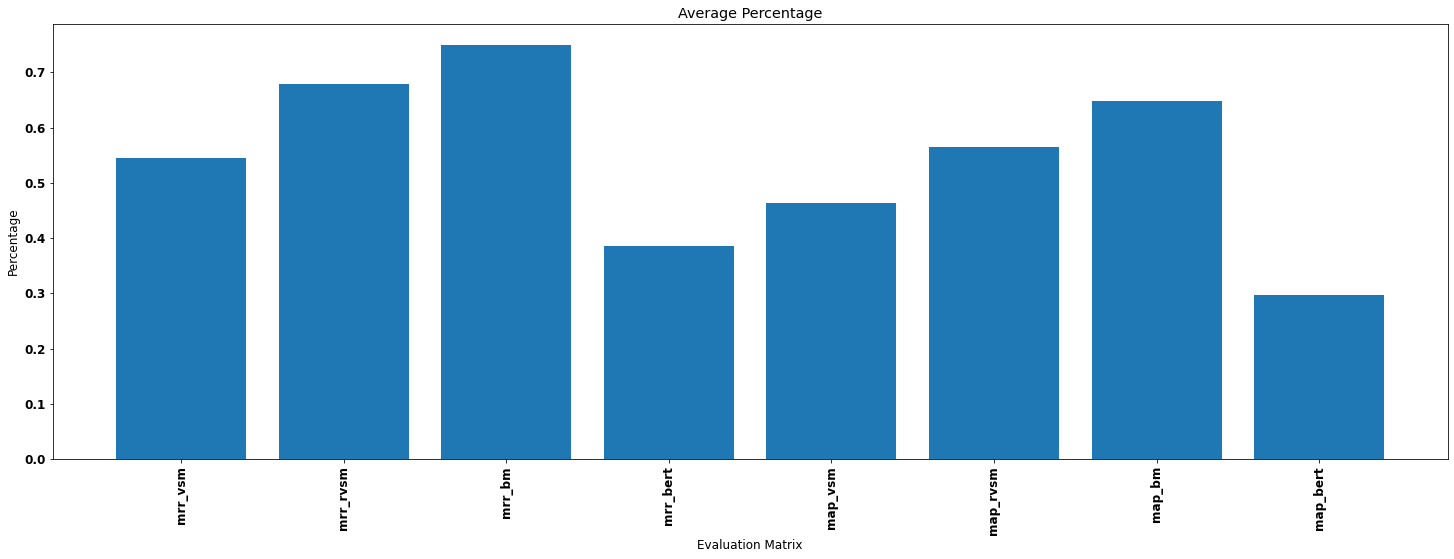

In [176]:
plt.figure(figsize=(25,8)) 
plt.bar(keys,values)
plt.title("Average Percentage")
plt.ylabel("Percentage")
plt.xlabel("Evaluation Matrix")
plt.xticks(rotation=90)
plt.show()

Reference:

https://mccormickml.com/2019/05/14/BERT-word-embeddings-tutorial/ </br>
https://gist.github.com/albahnsen/b02d2183c93067e3f248a428430c970e </br>
https://github.com/RosePasta/IRBL_for_DLSW/tree/main/2_scoring